Run a quick simulation to view the A matrix

### Key Parameters (Cheat Sheet)
- Grid: `Nx`, `Nz` are grid points in x/z; `Lx`, `Lz` are domain lengths (m). Derived spacing: `dx = Lx/(Nx-1)`, `dz = Lz/(Nz-1)`.
- Physics: sound speed `p['c']` (m/s) and absorption `p['alpha']` (1/s). Higher alpha = more damping.
- State/size: `N = Nx*Nz`. State is stacked as `[pressure (N); velocity (N)]` so `x` has length `2N`.
- System matrices: `A = [[0, I],[L, -alpha I]]`, `B` injects the source at `(sonar_ix, sonar_iz)`. `L` is a 2D Laplacian with mixed BCs.
- Boundaries: left/right absorbing, top pressure-release (sea surface), bottom rigid (seafloor). See `getParam_Sonar.py`.
- Source u(t): Gaussian-windowed sinusoid (`eval_u_Sonar`) with `f0` (Hz), `t0` (s), `sigma` (s), `A0` (Pa). Nonzero mainly within ±3·sigma.
- Sensors: hydrophone array `p['hydrophones']` with `z_pos` and `x_indices`; output `g(x)` returns pressures at those points.
- Sparse vs dense: `UseSparseMatrices=True` builds sparse `A`/`L` for larger grids and better performance.

Tip: Increase `Nx, Nz` for higher resolution (smaller `dx, dz`) but expect smaller stable time steps and higher compute cost.

System size: (400, 400)
Grid: 20 x 10 = 200 nodes
State vector size: 400
Source at grid point: (5, 5)


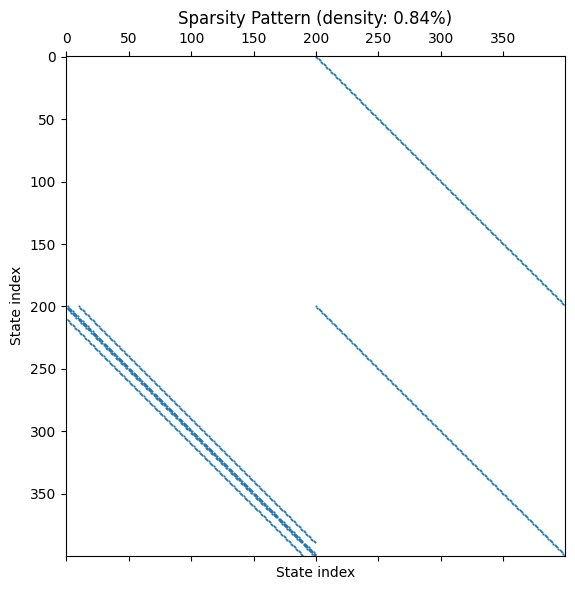

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar

Nx, Nz = 20, 10  
Lx, Lz = 100, 50  

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)

A = p['A']
B = p['B']
N = Nx * Nz

print(f"System size: {A.shape}")
print(f"Grid: {Nx} x {Nz} = {N} nodes")
print(f"State vector size: {2*N}")
print(f"Source at grid point: ({p['sonar_ix']}, {p['sonar_iz']})")

# Visualize sparsity pattern
fig, ax = plt.subplots(figsize=(6, 6))

ax.spy(A, markersize=0.5)
ax.set_title(f'Sparsity Pattern (density: {np.count_nonzero(A)/A.size:.2%})')
ax.set_xlabel('State index')
ax.set_ylabel('State index')

plt.tight_layout()
plt.show()


# What you see:
#   d[p]/dt = [0   I ][p] + [0]u
#    [v]      [L  -aI][v]   [b]

Next, run provided SimpleSolver. We don't expect stable behavior, since Forward Euler is non-ideal for wave propagation.

### Solver Controls and Stability
- Time step `w` is the Forward Euler step (seconds). Start with a small fraction of `max_dt_FE` from `getParam_Sonar`.
- `max_dt_FE` is a CFL-based estimate: roughly `min(dx, dz)/(√2 · c)` (with an extra safety factor).
- Number of steps `num_iter = ceil((t_stop - t_start)/w)`. Here, `t_stop` ≈ 2×domain crossing time = `2·max(Lx, Lz)/c`.
- If you see divergence/oscillations, reduce `w` or increase damping `alpha`.
- For larger grids, set `UseSparseMatrices=True` to keep memory and compute reasonable.
- `visualize=True` creates an animation; set `gif_file_name` to save the output.

Number of iterations: 2207
started running a simple solver, please wait...


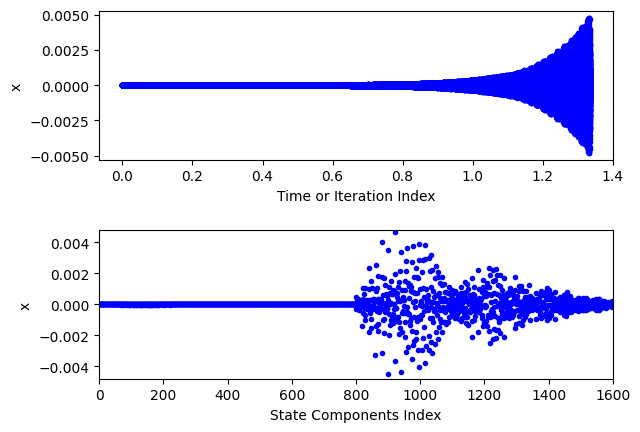

In [6]:
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar
from SimpleSolver import SimpleSolver

Nx, Nz = 40, 20  # grid resolution (x,z) [count]
Lx, Lz = 1000, 500  # domain size (m)

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

eval_u = eval_u_Sonar
eval_f = eval_f_Sonar

visualize = True
w = max_dt_FE * 0.1  # Forward Euler step (s); reduce if unstable
num_iter = int(np.ceil((t_stop - t_start) / w))  # steps to reach t_stop

print(f"Number of iterations: {num_iter}")

[X, t] = SimpleSolver(eval_f, x_start, p, eval_u, num_iter, w, visualize, gif_file_name="test_SimpleSolver_Sonar.gif")

### Hydrophone Plots
- Waterfall (top): one trace per hydrophone vs time (ms); traces are vertically offset for readability.
- Heatmap (bottom): hydrophone index (y) vs time (ms) with color = pressure (Pa).
- Change array geometry via `p['hydrophones']` (`z_pos`, `x_indices`) in `getParam_Sonar.py`.

Processing hydrophone data...


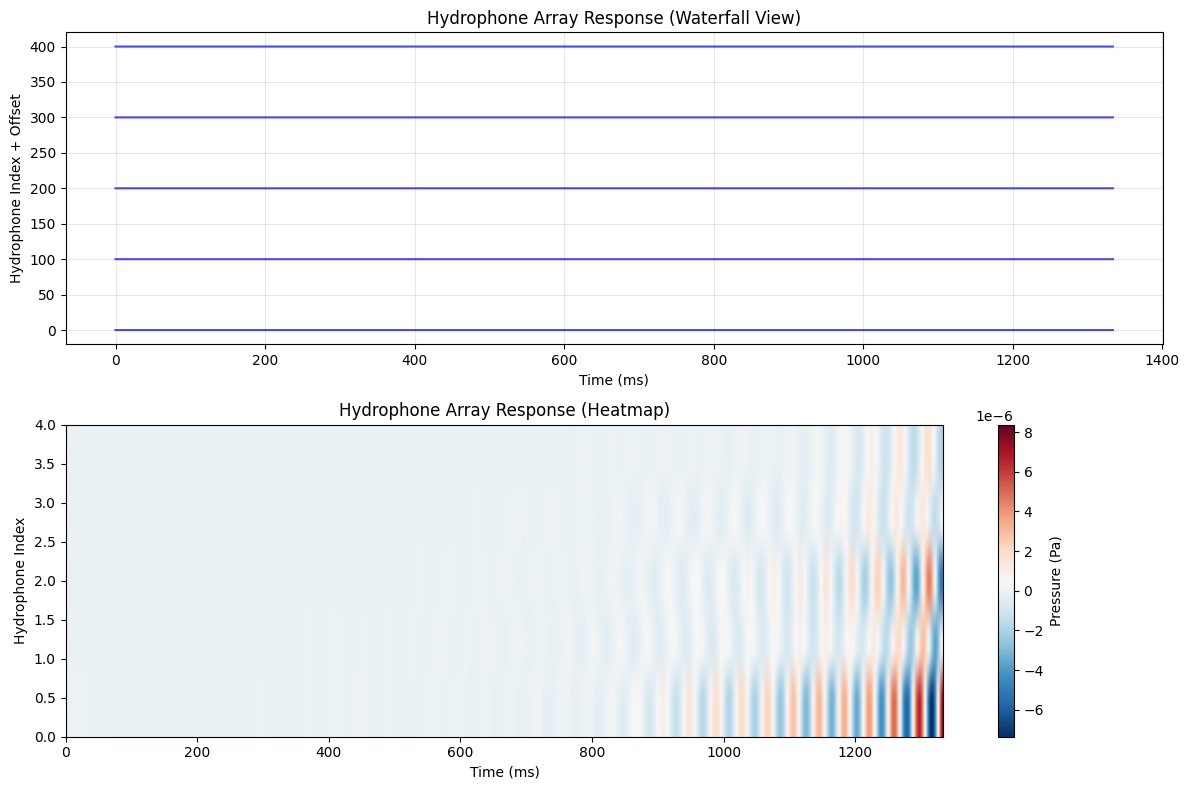

In [7]:
from eval_g_Sonar import eval_g_Sonar

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()

Implement our own suite of tests

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: -2.45e-13 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1

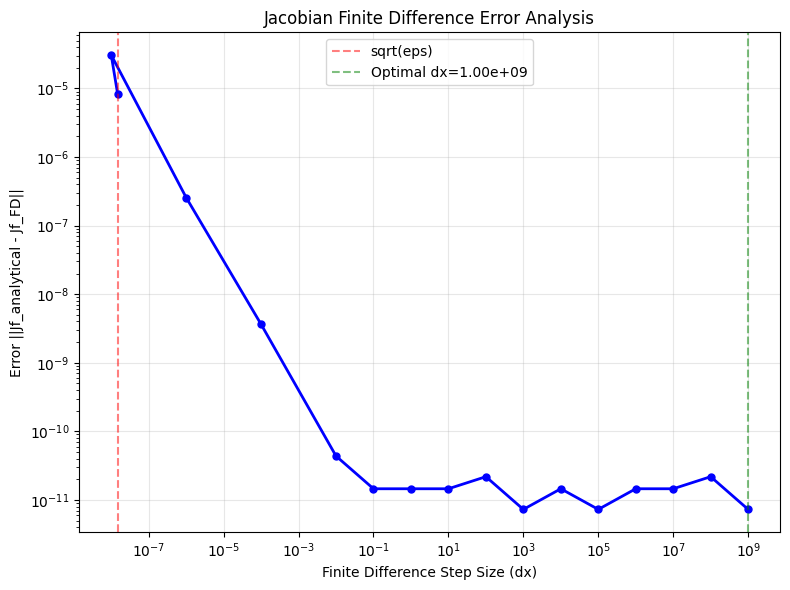


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!


(10, 0)

In [8]:
from test_Sonar import test_sonar_complete

test_sonar_complete()

# finite differences Jacobian is sitting right around machine precision
# our system is indeed linear! no truncation error